# Performance of CITE-seq antibodies

- In this notebook density plots are generated from CLR normalized ADT counts 
- For comparisons, signals of NK cell markers are compared between NK and B cells, and between NK cells and isotype controls (available for Neurips dataset).


### Dataset:
- Granja

### Used NK cell markers are selected based on recent papers and documentation of Mustjoki group; 

- Pfefferle, A., et al. (2019). A Temporal Transcriptional Map of Human Natural Killer Cell Differentiation. BioRxiv, 630657. https://doi.org/10.1101/630657
- Melsen, J. E., et al. (2022). Single-cell transcriptomics in bone marrow delineates CD56dimGranzymeK+ subset as intermediate stage in NK cell differentiation. Frontiers in immunology, 13, 1044398. https://doi.org/10.3389/fimmu.2022.1044398
- Yang, C., et al.(2019). Heterogeneity of human bone marrow and blood natural killer cells defined by single-cell transcriptome. Nature communications, 10(1), 3931. https://doi.org/10.1038/s41467-019-11947-7



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scvi
import scanpy as sc
import umap

from ridgeplot import ridgeplot

import warnings

warnings.filterwarnings('ignore')



Global seed set to 0
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=120, dpi_save=300, vector_friendly=True)

In [3]:
adata_granja = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_granja_norm.h5ad')

In [4]:
adata_granja.obs['cell_type'].unique().to_list()

['CD4+ T 1',
 'CD14+ monocyte 1',
 'Pre B',
 'Pro B',
 'CD8+ T',
 'Promonocyte',
 'CD14+ monocyte 2',
 'Plasmacytoid dendritic cell',
 'NK T 2',
 'Immature B',
 'Late erythoid precursor 1',
 'Pre B (cycling)',
 'NK',
 'Late erythoid precursor 3',
 'Early erythoid precursor',
 'CD16+ monocyte',
 'Conventional dendritic cell',
 'HSC',
 'NK T 1',
 'Late erythoid precursor 2',
 'Plasma B cell',
 'Stromal cell',
 'Megakaryocyte',
 nan]

In [5]:
#Select NK cells
granja_nk=adata_granja[adata_granja.obs['new_cell_type'] == 'NK' ]

In [6]:
granja_nk

View of AnnData object with n_obs × n_vars = 1033 × 8051
    obs: 'cell_type', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'eg_code', 'leiden_r1', 'new_cell_type', 'batch_group'
    uns: 'neighbors', 'new_cell_type_colors', 'umap'
    obsm: 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_granja'
    obsp: 'connectivities', 'distances'

In [7]:
granja_nk_prot=granja_nk.obsm['protein_expression_clr_granja']


In [8]:
granja_nk_prot.shape

(1033, 141)

In [9]:
#To exclude columns that contain only zeros

granja_nk_prot = pd.DataFrame(granja_nk_prot)
granja_nk_prot != 0
(granja_nk_prot != 0).any(axis=0)
granja_nk_prot.loc[:, (granja_nk_prot != 0).any(axis=0)]
granja_nk_prot = granja_nk_prot.loc[:, (granja_nk_prot != 0).any(axis=0)]


In [10]:
granja_nk_prot.shape

(1033, 14)

## Comparisons

In [11]:
#Surface protein markers for NK cells

nk_all = ['CD52',
 'CD127',
 'CD226',
 'CD335',
 'CD195',
 'CD56',
 'CD5',
 'CD69',
 'CD94',
 'CD16',
 'CD122',
 'CD57',
 'CD38',
 'CD158e1',
 'CD34',
 'TIGIT',
 'CD314',
 'CD7',
 'CD62L',
 'CD2',
 'CD27',
 'CX3CR1',
 'CD161',
 'CD155',
 'CD158b']

In [12]:
#Samples

samples_g=adata_granja.obs['POOL'].unique().tolist()
samples_g

['GSM4138872', 'GSM4138873', 'GSM4138874', 'GSM4138880', 'GSM4138885']

In [13]:
#checking which markers are used in Granja

listOfmarkers= nk_all

nk_granja= []

for x in listOfmarkers:
    if x in granja_nk_prot.columns:
        nk_granja.append(x)



In [14]:
nk_granja

['CD127', 'CD56', 'CD16', 'TIGIT']

In [15]:
#saving NK markers from all samples into a list

list_samples=[]

for sample in samples_g:
    eg = adata_granja[(adata_granja.obs['cell_type'] ==  "NK") | (adata_granja.obs['cell_type'] == "NK T 2") | (adata_granja.obs['cell_type'] == "NK T 1")]
    eg1=eg[eg.obs['POOL'] == sample]
    prot=eg1.obsm['protein_expression_clr_granja']
    prot_marker=prot[nk_granja]
    list_samples.append(prot_marker)


In [16]:
string= " NK cells"

samples_g_nk = [x + string for x in samples_g]

In [17]:
list_granja=[]

for i in range(len(list_samples)):
    sample= list_samples[i]
    sample["Sample"]=samples_g_nk[i]
    list_granja.append(sample)

In [18]:
df_all_g=pd.concat(list_granja, axis=0)


In [19]:
df_all_g.shape

(1033, 5)

In [20]:
samples_g

['GSM4138872', 'GSM4138873', 'GSM4138874', 'GSM4138880', 'GSM4138885']

In [21]:
adata_granja.obs["cell_type"].unique().tolist()

['CD4+ T 1',
 'CD14+ monocyte 1',
 'Pre B',
 'Pro B',
 'CD8+ T',
 'Promonocyte',
 'CD14+ monocyte 2',
 'Plasmacytoid dendritic cell',
 'NK T 2',
 'Immature B',
 'Late erythoid precursor 1',
 'Pre B (cycling)',
 'NK',
 'Late erythoid precursor 3',
 'Early erythoid precursor',
 'CD16+ monocyte',
 'Conventional dendritic cell',
 'HSC',
 'NK T 1',
 'Late erythoid precursor 2',
 'Plasma B cell',
 'Stromal cell',
 'Megakaryocyte',
 nan]

In [22]:
#saving NK markers from all samples into a list, B cells

list_samples_b=[]

for sample in samples_g:
    eg=adata_granja[adata_granja.obs['new_cell_type'] == 'B']
    eg1=eg[eg.obs['POOL'] == sample]
    prot=eg1.obsm['protein_expression_clr_granja']
    prot_marker=prot[nk_granja]
    list_samples_b.append(prot_marker)




In [23]:
#Adding cell type information after sample name
string= " B cells"

samples_g_b = [x + string for x in samples_g]


In [24]:
list_granja_b=[]

for i in range(len(list_samples_b)):
    sample= list_samples_b[i]
    sample["Sample"]=samples_g_b[i]
    list_granja_b.append(sample)

# creating df

df_all_g_b=pd.concat(list_granja_b, axis=0)

In [25]:
#Combining NK and B cell df

df=pd.concat([df_all_g, df_all_g_b], axis=0)

In [26]:
#Assigning sample pairs (one sample, NK + B cells)
data1 = df[(df['Sample'] == "GSM4138872 NK cells") | (df['Sample'] == 'GSM4138872 B cells')].assign(Samplepair= 1)   
data2 = df[(df['Sample'] == "GSM4138873 NK cells") | (df['Sample'] == 'GSM4138873 B cells')].assign(Samplepair= 2)   


In [27]:
cdf_granja = pd.concat([data1, data2])

In [28]:
cdf_granja.columns

Index(['CD127', 'CD56', 'CD16', 'TIGIT', 'Sample', 'Samplepair'], dtype='object')

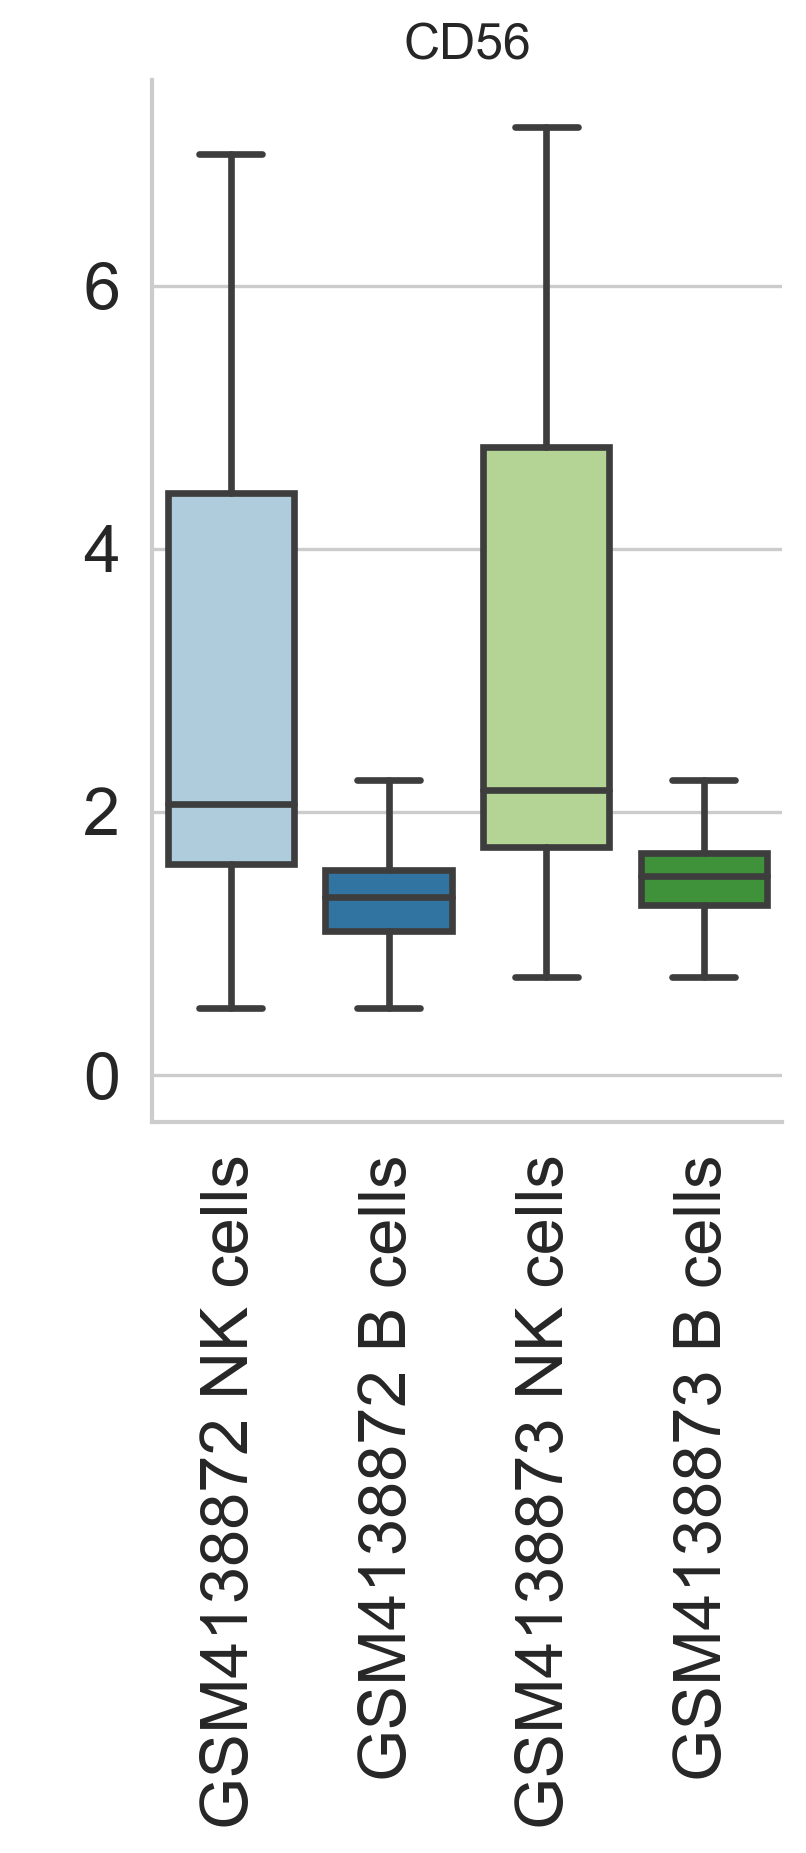

In [33]:
#CD56

sns.set_theme(style = "whitegrid", font_scale= 0.7)

ax = sns.catplot(x="Sample", y="CD56",
            aspect=.4,fliersize=0,dodge=False, 
            kind="box",palette = 'Paired', data=cdf_granja,
                 linewidth = 2,
            legend = "CD57")
ax.set_xticklabels(rotation = 90)
ax.fig.set_size_inches(5, 5)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.title("CD56", fontsize=15)
ax.set(xlabel=None)
ax.set_ylabels(' ', fontsize= 15)
plt.show()

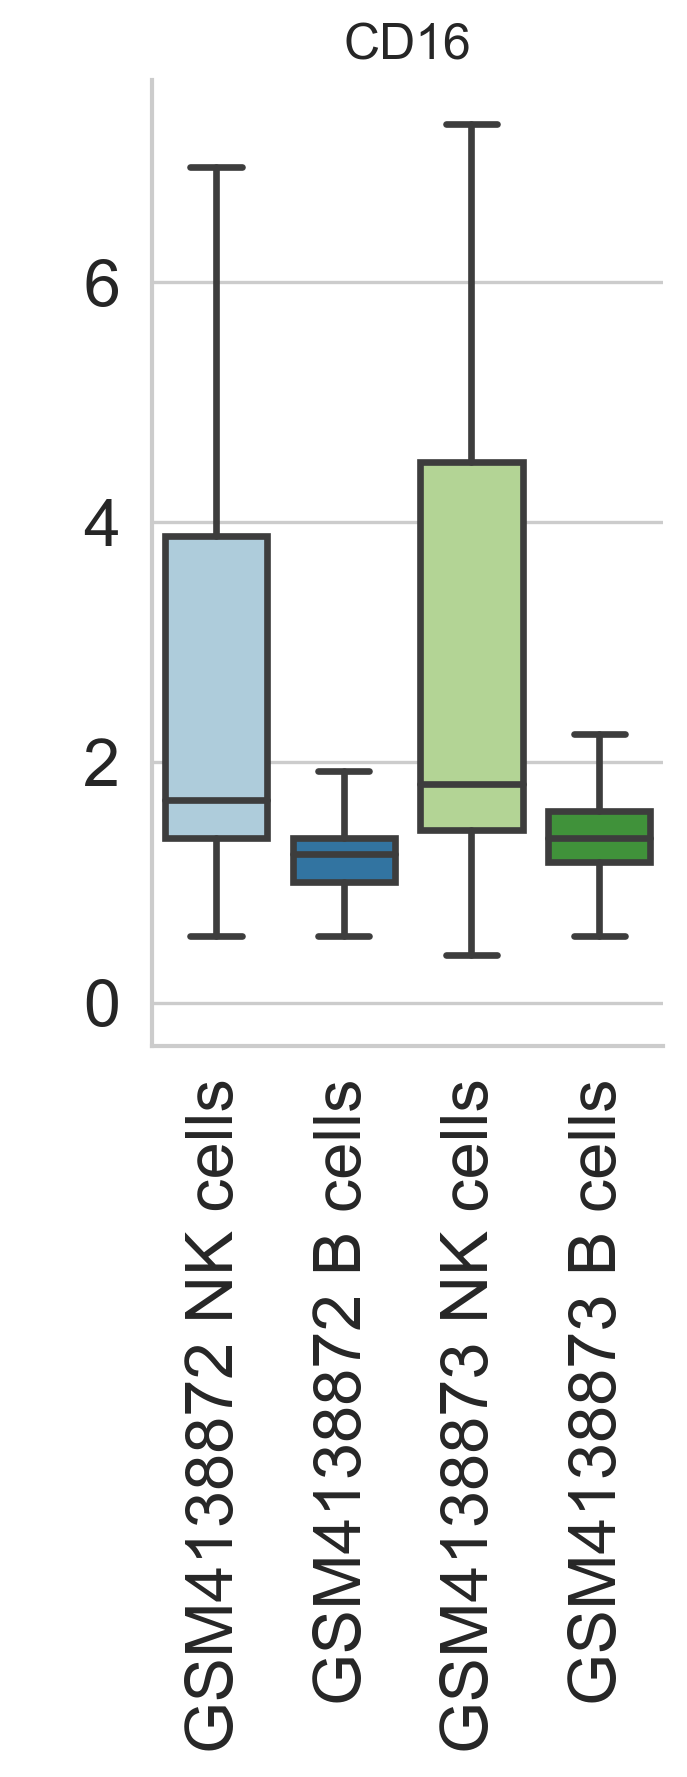

In [34]:
#CD16

sns.set_theme(style = "whitegrid", font_scale= 1.5)
ax = sns.catplot(x="Sample", y="CD16",
            aspect=.4,fliersize=0,dodge=False, 
            kind="box",palette = 'Paired', data=cdf_granja,
                 linewidth = 2,
            legend = "CD16")
ax.set_xticklabels(rotation = 90)
ax.fig.set_size_inches(5, 5)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.title("CD16", fontsize=15)
ax.set(xlabel=None)
ax.set_ylabels(' ', fontsize= 15)
plt.show()